## Derive emission based historical ERFs:
We use timeseries for historical emissions/concentrations and then scale these with the 1750-2019 ERF from Thornhill (2019)/bill collins plot to derive ERF timeseries. 
For short lived components, we use change in emissions from CEDS:
- NOx, VOC/CO, SO2, OC, BC, NH3
For longer lived components, we use change in concentrations from chap 2:
- CO2, CH4, N2O, HC

For ERF from VOC/CO we use emissions of CO to scale. 
For HC we use the HC from Thornhill (which includes only CFCs and HCFCs) and additionally, we use HFC concentrations (ch2) and multipy with radiative efficiencies (RE) from Hodnebrog et al (2019). 
HC is then the sum of the HC from Thornhill (scaled with concentrations) and the HFC ERF.

Finally, these ERFs are integrated with the IRF and the change in GSAT is calculated. 


### References:
Hodnebrog, Ø, B. Aamaas, J. S. Fuglestvedt, G. Marston, G. Myhre, C. J. Nielsen, M. Sandstad, K. P. Shine, and T. J. Wallington. “Updated Global Warming Potentials and Radiative Efficiencies of Halocarbons and Other Weak Atmospheric Absorbers.” Reviews of Geophysics 58, no. 3 (2020): e2019RG000691. https://doi.org/10.1029/2019RG000691


Thornhill, Gillian D., William J. Collins, Ryan J. Kramer, Dirk Olivié, Ragnhild B. Skeie, Fiona M. O’Connor, Nathan Luke Abraham, et al. “Effective Radiative Forcing from Emissions of Reactive Gases and Aerosols – a Multi-Model Comparison.” Atmospheric Chemistry and Physics 21, no. 2 (January 21, 2021): 853–74. https://doi.org/10.5194/acp-21-853-2021.

## Final ERFs in 2019 based on Thornhill 2021

<img src="../../results/figures_historic_attribution/attribution_1750_2019.png" alt="drawing" width="800"/>


In [1]:
import numpy as np
import pandas as pd

import glob
from pathlib import Path

from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR, BASE_DIR, OUTPUT_DATA_DIR, RESULTS_DIR

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


### File paths

In [2]:
INPUT_DATA_DIR

PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in')

In [3]:
fn_concentrations = INPUT_DATA_DIR/ 'historical_delta_GSAT/LLGHG_history_AR6_v9_updated.xlsx'
path_emissions = INPUT_DATA_DIR / 'historical_delta_GSAT/CEDS_v2021-02-05_emissions/'

# file path table of ERF 2019-1750
fp_collins = RESULTS_DIR /'tables_historic_attribution/table_mean_smb_orignames.csv'

### Output file paths:

In [4]:
fn_output_ERF = OUTPUT_DATA_DIR/'historic_delta_GSAT/hist_ERF_est.csv'
fn_output_ERF_2019= OUTPUT_DATA_DIR/'historic_delta_GSAT/2019_ERF_est.csv'
fn_output_decomposition = OUTPUT_DATA_DIR / 'historic_delta_GSAT/hist_ERF_est_decomp.csv'

## Load concentration file and interpolate from 1750 to 1850

In [5]:
df_conc = pd.read_excel(fn_concentrations, header=22, index_col=0)
# For C8F18 there appears to be an error in the spreadsheet where 2015 is entered as zero, presumably 0.09 but treat as missing
df_conc.loc[2015, 'C8F18'] = np.nan


# datetime index
df_conc.index = pd.to_datetime(df_conc.index, format='%Y')

# resample to yearly, i.e. NaNs will be filled between 1750 and 1850:
df_conc = df_conc.resample('Y').first()#.interpolate()
# Interpolate:
df_conc = df_conc.interpolate(method='linear',limit_area = 'inside') # 'inside' only fill values with valid on both sides. 
# reset index to year
df_conc.index = df_conc.index.year
df_conc

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.300,729.2000,270.1000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1751,278.372,729.9840,270.1200,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1752,278.444,730.7680,270.1400,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1753,278.516,731.5520,270.1600,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1754,278.588,732.3360,270.1800,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,399.420,1834.0055,328.3025,83.4145,28.042,9.985158,18.0910,17.5655,6.5970,1.096239,...,0.062,0.11,NaN,0.412,0.066,0.68,1.05,0.39897,NaN,1.02
2016,402.850,1842.1665,329.1240,89.4825,28.950,11.972602,20.4815,19.1555,6.6600,1.205802,...,NaN,NaN,NaN,NaN,0.067,NaN,1.04,0.42501,NaN,NaN
2017,405.000,1849.2365,330.0400,95.7485,29.975,14.153317,23.2450,20.8340,6.8175,1.327504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43989,NaN,NaN


In [6]:
[c for c in df_conc.columns if 'CFC' in c]

['CFC-12',
 'CFC-11',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'CFC-13',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CFC-112',
 'CFC-112a',
 'CFC-113a',
 'CFC-114a',
 'HCFC-133a',
 'HCFC-31',
 'HCFC-124']

## Emissions:

In [7]:
fl =list(path_emissions.glob('*global_CEDS_emissions_by_sector_2021_02_05.csv'))

In [8]:
list_df_em=[]
units_dic = {}
for fn in fl:
    _df = pd.read_csv(fn)
    u_em = _df['em'].unique()
    if len(u_em)>1:
        print('double check, emission labels :')
        print(u_em)
    _em = u_em[0]
    u_units = _df['units'].unique()
    if len(u_units)>1:
        print('double check, units labels :')
        print(u_units)
    _un = u_units[0]
    _df_s = _df.drop(['em','sector','units'], axis=1).sum()
    _df_s.index = pd.to_datetime(_df_s.index, format='X%Y').year
    _df = pd.DataFrame(_df_s, columns=[_em])
    units_dic[_em]=_un
    list_df_em.append(_df)

In [9]:
df_emissions = pd.concat(list_df_em, axis=1)

In [10]:
df_emissions

,NMVOC,NH3,N2O,CO2,CH4,SO2,NOx,CO,BC,OC
1750,7023.641263,3269.176758,NaN,8.576757e+03,NaN,328.789104,185.580971,67762.973185,515.765609,2227.719109
1751,7042.533954,3278.144906,NaN,8.576757e+03,NaN,333.628884,186.076547,67946.051473,516.971538,2234.522070
1752,7061.396094,3287.111716,NaN,8.580118e+03,NaN,337.206293,186.576018,68128.860406,518.178349,2241.318148
1753,7080.216581,3296.077167,NaN,8.580118e+03,NaN,340.229988,187.070914,68311.163486,519.381789,2248.101520
1754,7099.006515,3305.041280,NaN,8.583478e+03,NaN,343.545708,187.569704,68493.197158,520.586112,2254.878009
...,...,...,...,...,...,...,...,...,...,...
2015,149389.741081,59038.504361,9583.586380,3.450186e+07,359770.677166,91935.652997,124803.357256,565944.477777,6032.311194,13800.102858
2016,148702.416915,59617.940857,9577.935584,3.449306e+07,357309.033465,88171.800222,123173.953426,548345.493004,5930.684820,13823.964613
2017,148911.160658,60261.516203,9610.590560,3.498511e+07,357485.146366,84928.764295,123024.332504,541357.744387,5927.165439,13826.957269
2018,147892.709851,60791.374593,9692.574706,3.586313e+07,360716.548043,84446.146636,122148.081545,536103.071094,5889.262292,13746.675390


In [11]:
units_dic

{'NMVOC': 'ktNMVOC',
 'NH3': 'ktNH3',
 'N2O': 'ktN2O',
 'CO2': 'ktCO2',
 'CH4': 'ktCH4',
 'SO2': 'ktSO2',
 'NOx': 'ktNO2',
 'CO': 'ktCO',
 'BC': 'ktC',
 'OC': 'ktC'}

## Load CMIP ERFs (bill collins)

In [12]:
df_collins = pd.read_csv(fp_collins, index_col=0)
df_collins.index = df_collins.index.rename('emission_experiment')

In [13]:
df_collins#.columns

,CO2,CH4_lifetime,Strat_H2O,Aerosol,Cloud,O3,HC,N2O
emission_experiment,,,,,,,,
CO2,2.057554,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
CH4,0.017549,0.844457,0.05,-0.003448,0.018421,0.279179,0.00,0.00
N2O,0.000000,-0.035967,0.00,-0.002717,0.042503,0.024311,0.00,0.21
HC,0.000053,-0.050927,0.00,-0.010501,-0.017419,-0.164586,0.41,0.00
NOx,0.000000,-0.380025,0.00,-0.011912,-0.014458,0.120237,0.00,0.00
VOC,0.069491,0.162462,0.00,-0.003344,0.008884,0.210860,0.00,0.00
SO2,0.000000,0.000000,0.00,-0.214702,-0.683985,0.000000,0.00,0.00
OC,0.000000,0.000000,0.00,-0.066129,-0.133067,0.000000,0.00,0.00
BC,0.000000,0.000000,0.00,0.123707,-0.060878,0.000000,0.00,0.00


In [14]:
df_collins.sum()#.columns

CO2             2.144647
CH4_lifetime    0.540000
Strat_H2O       0.050000
Aerosol        -0.220000
Cloud          -0.840000
O3              0.470000
HC              0.410000
N2O             0.210000
dtype: float64

In [15]:
forcing_total_collins = df_collins.sum(axis=1)#['Total']
forcing_total_collins 

emission_experiment
CO2    2.057554
CH4    1.206157
N2O    0.238130
HC     0.166620
NOx   -0.286158
VOC    0.448353
SO2   -0.898688
OC    -0.199196
BC     0.062828
NH3   -0.030954
dtype: float64

In [16]:
import matplotlib.pyplot as plt

In [17]:
def scale_ERF(forcing_tot, df_agent, spec, spec_cmip, end_year=2019, base_year=1750):
    delta_spec_end_year = df_agent[spec].loc[end_year]- df_agent[spec].loc[base_year] # co2 concentration in 2019
    delta_spec = df_agent[spec] -df_agent[spec].loc[base_year]# co2 concentration 1750-2019
    aerchemmip_endyear_forcing = forcing_tot[spec_cmip] # from Bill collins
    forcing_spec = aerchemmip_endyear_forcing*delta_spec/delta_spec_end_year # scale by concentrations
    return forcing_spec

CO2
N2O
CH4


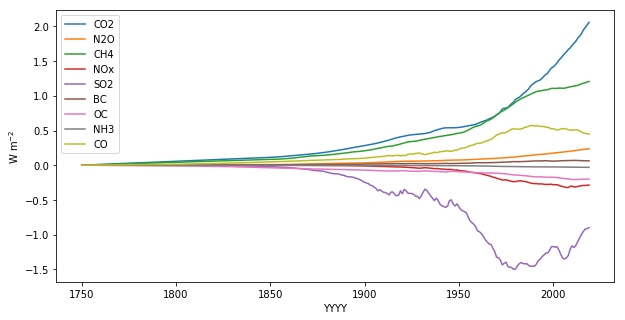

In [18]:
fig, ax = plt.subplots(figsize=[10,5])

ERFs ={}
for spec in ['CO2','N2O','CH4']:
    forcing_spec = scale_ERF(forcing_total_collins, df_conc,spec, spec)# # scale by concentrations

    print(spec)
    forcing_spec.plot(label=spec)
    ERFs[spec]=forcing_spec





spec = 'NOx'
for spec in ['NOx','SO2','BC','OC','NH3']:
    forcing_spec = scale_ERF(forcing_total_collins, df_emissions,spec, spec)# scale by emissions

    ERFs[spec]=forcing_spec

    forcing_spec.plot(label=spec)
    
    
# VOC: scale with CO emissions because these are mostly the same
spec = 'CO'

forcing_spec = scale_ERF(forcing_total_collins, df_emissions,spec, 'VOC')#aerchemmip_2019_forcing*delta_spec_conc/delta_spec_conc2019 # scale by concentrations

ERFs['VOC']=forcing_spec

forcing_spec.plot(label=spec)


plt.ylabel('W m$^{-2}$')

plt.legend(loc='upper left')

# HFCs:
For HFCs we use the RE from Hodnebrog et al 2019 and the concentrations from chapter two to calculate the ERF. 

## Hodnebrog:

Read in table 3 from Hodnebrog et al 

In [19]:
fp_hodnebrog = INPUT_DATA_DIR/'hodnebrog_tab3.csv'

In [20]:
df_hodnebrog = pd.read_csv(fp_hodnebrog, index_col=[0,1],header=[0,1])
df_HFC =  df_hodnebrog.loc[('Hydrofluorocarbons',)]
df_HFC

/home/sarambl/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


Info                        Info              tau (yr)             \
Identifier/name          Formula        CASRN   H2013a WMO (2019)   
HFC-23                      CHF3      75-46-7    222.0      228.0   
HFC-32                     CH2F2      75-10-5      5.2        5.4   
HFC-125                  CHF2CF3     354-33-6     28.2       30.0   
HFC-134a                 CH2FCF3     811-97-2     13.4       14.0   
HFC-143a                  CH3CF3     420-46-2     47.1       51.0   
HFC-152a                 CH3CHF2      75-37-6      1.5        1.6   
HFC-227ea              CF3CHFCF3     431-89-0     38.9       36.0   
HFC-236fa              CF3CH2CF3     690-39-1    242.0      213.0   
HFC-245fa             CHF2CH2CF3     460-73-1      7.7        7.9   
HFC-365mfc          CH3CF2CH2CF3     406-58-6      8.7        8.9   
HFC-43-10mee     CF3CHFCHFCF2CF3  138495-42-8     16.1       17.0   

Info            RE (Wm-2ppb-1)           GWP(100)            
Identifier/name          H2013 This work    H2013 This work  
HFC-23                    0.17      0.19    12400   15500.0  
HFC-32                    0.11      0.11      677     809.0  
HFC-125                   0.23      0.23     3170    3940.0  
HFC-134a                  0.16      0.17     1300    1600.0  
HFC-143a                  0.16      0.17     4800    6130.0  
HFC-152a                  0.10      0.10      138     172.0  
HFC-227ea                 0.26      0.27     3350    3800.0  
HFC-236fa                 0.24      0.25     8060    9210.0  
HFC-245fa                 0.24      0.24      858    1010.0  
HFC-365mfc                0.22      0.23      804     959.0  
HFC-43-10mee              0.42      0.36     1650    1680.0

In [21]:
RE_df = df_HFC['RE (Wm-2ppb-1)'].transpose()
#RE_df = RE_df.reset_index().rename({'level_1':'Species'},axis=1).set_index('Species').drop('level_0', axis=1)
RE_df#.transpose().loc['This work']*

,HFC-23,HFC-32,HFC-125,HFC-134a,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,HFC-43-10mee
Identifier/name,,,,,,,,,,,
H2013,0.17,0.11,0.23,0.16,0.16,0.1,0.26,0.24,0.24,0.22,0.42
This work,0.19,0.11,0.23,0.17,0.17,0.1,0.27,0.25,0.24,0.23,0.36


In [22]:
df_conc[RE_df.columns] - df_conc[RE_df.columns].loc[1750] 

,HFC-23,HFC-32,HFC-125,HFC-134a,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,HFC-43-10mee
YYYY,,,,,,,,,,,
1750,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1751,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1752,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1753,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1754,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2015,28.042,9.984940,18.0910,83.4145,17.5655,6.5970,1.096235,0.142,2.232,0.855653,0.254
2016,28.950,11.972384,20.4815,89.4825,19.1555,6.6600,1.205798,0.153,2.426,0.931363,0.264
2017,29.975,14.153098,23.2450,95.7485,20.8340,6.8175,1.327500,0.166,2.636,0.990426,0.272


In [23]:
ERF_HFCs = (df_conc[RE_df.columns] -   df_conc[RE_df.columns].loc[1750])*RE_df.loc['This work']*1e-3 #ppt to ppb
ERF_HFCs['HFCs'] = ERF_HFCs.sum(axis=1)
ERF_HFCs

,HFC-23,HFC-32,HFC-125,HFC-134a,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,HFC-43-10mee,HFCs
YYYY,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.005328,0.001098,0.004161,0.014180,0.002986,0.000660,0.000296,0.000035,0.000536,0.000197,0.000091,0.029569
2016,0.005501,0.001317,0.004711,0.015212,0.003256,0.000666,0.000326,0.000038,0.000582,0.000214,0.000095,0.031918
2017,0.005695,0.001557,0.005346,0.016277,0.003542,0.000682,0.000358,0.000042,0.000633,0.000228,0.000098,0.034457


Text(0,0.5,'W/m2')

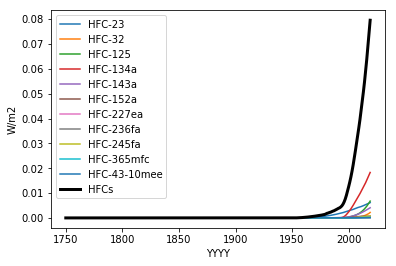

In [24]:
for c in ERF_HFCs.columns[:-1]:
    ERF_HFCs[c].plot(label=c)
ERF_HFCs.sum(axis=1).plot(label='HFCs',color='k',linewidth=3)
plt.legend()
plt.ylabel('W/m2')

In [25]:
# We use CFC-12 emissions for HC
spec = 'CFC-12'
forcing_HC = scale_ERF(forcing_total_collins, df_conc,spec, 'HC') # scale by concentrations



ERFs['HC'] = forcing_HC + ERF_HFCs['HFCs']

ERF_HFCs['HFCs']

YYYY
1750    0.000000
1751    0.000000
1752    0.000000
1753    0.000000
1754    0.000000
          ...   
2015    0.029569
2016    0.031918
2017    0.034457
2018    0.037082
2019    0.039772
Name: HFCs, Length: 270, dtype: float64

In [26]:
df_ERF = pd.concat(ERFs, axis=1)#['CO2'].loc[1752]
df_ERF.columns

Index(['CO2', 'N2O', 'CH4', 'NOx', 'SO2', 'BC', 'OC', 'NH3', 'VOC', 'HC'], dtype='object')

In [27]:
forcing_HC[2019]

0.1666198144560032

### Add HFC

In [28]:
df_collins['HFCs']=0
df_collins.loc['HC','HFCs']=ERF_HFCs['HFCs'][2019]
df_collins

,CO2,CH4_lifetime,Strat_H2O,Aerosol,Cloud,O3,HC,N2O,HFCs
emission_experiment,,,,,,,,,
CO2,2.057554,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000
CH4,0.017549,0.844457,0.05,-0.003448,0.018421,0.279179,0.00,0.00,0.000000
N2O,0.000000,-0.035967,0.00,-0.002717,0.042503,0.024311,0.00,0.21,0.000000
HC,0.000053,-0.050927,0.00,-0.010501,-0.017419,-0.164586,0.41,0.00,0.039772
NOx,0.000000,-0.380025,0.00,-0.011912,-0.014458,0.120237,0.00,0.00,0.000000
VOC,0.069491,0.162462,0.00,-0.003344,0.008884,0.210860,0.00,0.00,0.000000
SO2,0.000000,0.000000,0.00,-0.214702,-0.683985,0.000000,0.00,0.00,0.000000
OC,0.000000,0.000000,0.00,-0.066129,-0.133067,0.000000,0.00,0.00,0.000000
BC,0.000000,0.000000,0.00,0.123707,-0.060878,0.000000,0.00,0.00,0.000000


In [29]:
df_ERF

,CO2,N2O,CH4,NOx,SO2,BC,OC,NH3,VOC,HC
1750,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
1751,0.001126,0.000077,0.000832,-0.000001,-0.000053,0.000014,-0.000119,-0.000005,0.000177,0.000000
1752,0.002252,0.000154,0.001663,-0.000002,-0.000091,0.000028,-0.000237,-0.000010,0.000354,0.000000
1753,0.003378,0.000230,0.002495,-0.000004,-0.000124,0.000043,-0.000356,-0.000014,0.000530,0.000000
1754,0.004505,0.000307,0.003326,-0.000005,-0.000160,0.000057,-0.000474,-0.000019,0.000706,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,1.894420,0.223577,1.171873,-0.295162,-0.994594,0.065084,-0.201918,-0.029726,0.481837,0.200667
2016,1.948068,0.226732,1.180530,-0.291303,-0.953730,0.063885,-0.202334,-0.030035,0.464815,0.201919
2017,1.981696,0.230251,1.188029,-0.290949,-0.918519,0.063844,-0.202386,-0.030378,0.458057,0.203356
2018,2.019078,0.234670,1.197088,-0.288873,-0.913279,0.063397,-0.200986,-0.030660,0.452975,0.204997


### Decompose matrix:

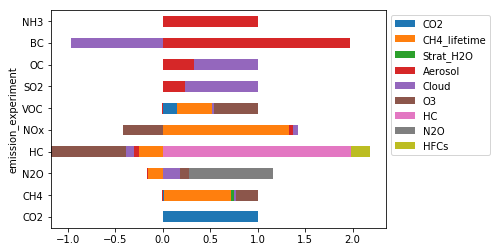

In [30]:
df_coll_t = df_collins.transpose()
if 'Total' in df_coll_t.index:
    df_coll_t = df_coll_t.drop('Total')
# scale by total:
scale = df_coll_t.sum()
# normalized ERF: 
df_col_normalized = df_coll_t/scale
#
df_col_normalized.transpose().plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1,1))

## Save ERFs

In [31]:
fn_output_ERF

PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/historic_delta_GSAT/hist_ERF_est.csv')

In [32]:
fn_output_ERF.parent.mkdir(parents=True,exist_ok=True)
df_ERF.to_csv(fn_output_ERF)
df_col_normalized.to_csv(fn_output_decomposition)
df_collins.to_csv(fn_output_ERF_2019)

In [33]:
df_ERF

,CO2,N2O,CH4,NOx,SO2,BC,OC,NH3,VOC,HC
1750,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
1751,0.001126,0.000077,0.000832,-0.000001,-0.000053,0.000014,-0.000119,-0.000005,0.000177,0.000000
1752,0.002252,0.000154,0.001663,-0.000002,-0.000091,0.000028,-0.000237,-0.000010,0.000354,0.000000
1753,0.003378,0.000230,0.002495,-0.000004,-0.000124,0.000043,-0.000356,-0.000014,0.000530,0.000000
1754,0.004505,0.000307,0.003326,-0.000005,-0.000160,0.000057,-0.000474,-0.000019,0.000706,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,1.894420,0.223577,1.171873,-0.295162,-0.994594,0.065084,-0.201918,-0.029726,0.481837,0.200667
2016,1.948068,0.226732,1.180530,-0.291303,-0.953730,0.063885,-0.202334,-0.030035,0.464815,0.201919
2017,1.981696,0.230251,1.188029,-0.290949,-0.918519,0.063844,-0.202386,-0.030378,0.458057,0.203356
2018,2.019078,0.234670,1.197088,-0.288873,-0.913279,0.063397,-0.200986,-0.030660,0.452975,0.204997
